# Deep Learning: I

*N. Pol (2025)*

This lecture and notebook are based on the "Classification3", "NeuralNetworks", and "TensorFlowCodeOnly" lectures of of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), which in turn are based on materials from Andy Connolly, and Ivezic et al. Chapter 9, Andy Connolly's [blog](http://connolly.github.io/introAstroML/blog/regression.html), and Aurelien Geron's [book](https://github.com/ageron/handson-ml2). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 9.
- Many blogs and videos.
- Free online book! http://neuralnetworksanddeeplearning.com/index.html

---

## Contents
* [Loss functions](#one)
* [Gradient descent](#two)
* [AdaBoost](#three)
* [Neural networks](#four)
    
---

***Exercises required for class participation are in <font color='red'>red</font>.***

---

We'll be talking about neural networks and deep learning today. [This](https://www.youtube.com/watch?v=bxe2T-V8XRs&list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU&ab_channel=WelchLabs) series of videos provides a particularly helpful intro that simplifies the explanation. Before we delve into neural networks, let me introduce a few useful concepts.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Loss Functions <a class="anchor" id="one"></a>

A **[loss function](https://en.wikipedia.org/wiki/Loss_functions_for_classification)** is like a cost function, or a likelihood, or optimization function, or an objective function. We're trying to minimize the offset between a model and some data. The difference with a loss function is that we evaluate it on a single training example rather than the full data set.

- Whether you realize it or not, you are typically working with **$L2$ loss functions**:
$$(y-f(x))^2,$$
where the corresponding ***cost function*** is the mean of those for all $x_i$ or the **Mean Squared Error (MSE)** (just another name for $\chi^2$, which of course is related to the probability of Gaussian uncertainties).


- We also talked about **$L1$ loss functions** way back when we looked at the ***Huber loss*** which was more robust to outliers:
$$|y-f(x)|,$$
and the L1 penalty was important in LASSO regression.

For classification we plot the **loss vs. $(y\times f(x))$**, where the latter corresponds to the known class (either $+1$ or $-1$) times the predicted value. If that product is positive, we predict $+1$. If it is negative, we predict $-1$. We define the loss to be zero for $y*f(x)=1$, that is, when we have gotten the right answer.

So what do the mean squared error (MSE or $L2$) and mean absolute error (MAE or $L1$) look like for classification?

In [2]:
# Mathematical formulas for various loss functions
def log_loss(raw_model_output):
    return np.log(1+np.exp(-raw_model_output))

def hinge_loss(raw_model_output):
    return np.maximum(0,1-raw_model_output)
 
def l2(raw_model_output):
    return (raw_model_output-1)**2  

def l1(raw_model_output):
    return np.abs(raw_model_output-1)  
 
def zero_one(raw_model_output):
    return np.where(raw_model_output < 0, 1, 0)   

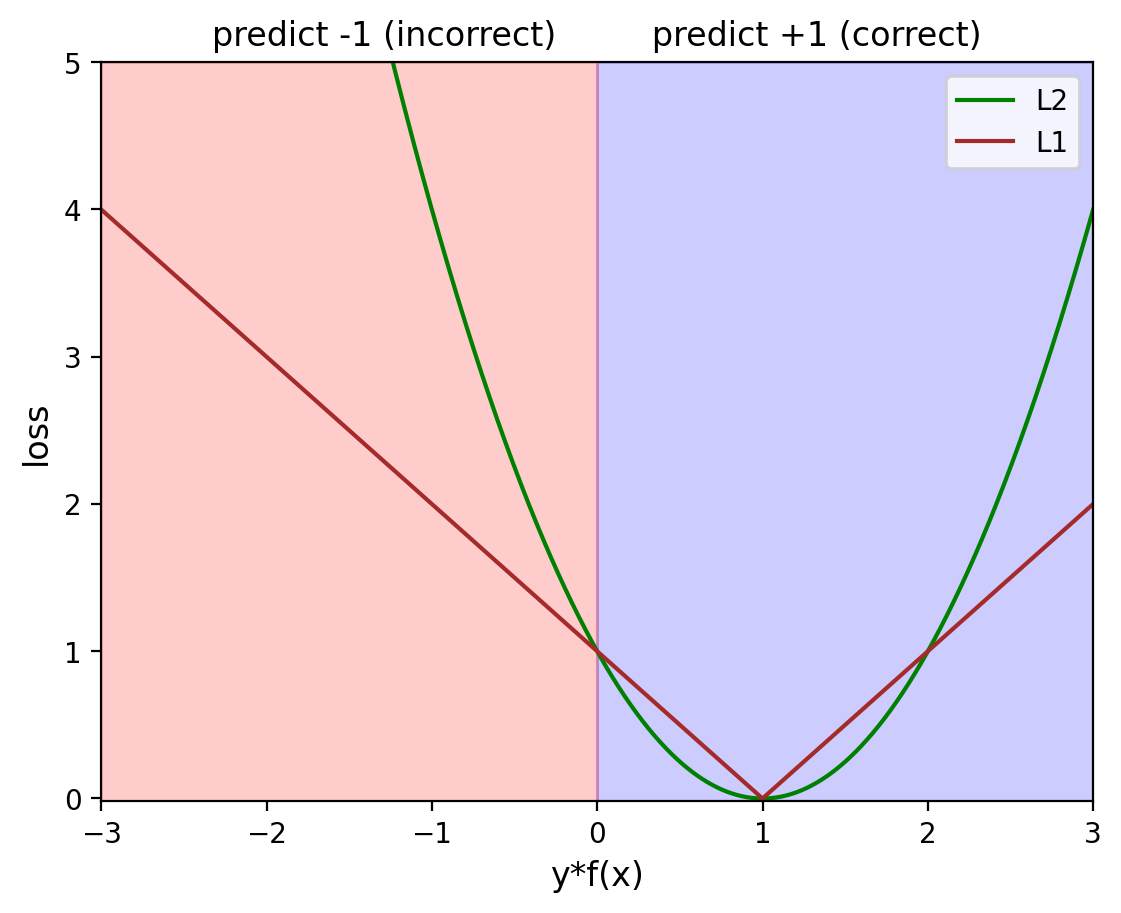

In [3]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
plt.plot(grid, l2(grid), "g", label='L2')
plt.plot(grid, l1(grid), "brown", label='L1')

plt.fill_between([0,3], y1=-0.02, y2=5,
                 color="b", alpha=0.2)
plt.fill_between([-3,0], y1=-0.02, y2=5,
                 color="r", alpha=0.2)
plt.xlim([-3,3])
plt.ylim([-0.02,5])
plt.xlabel("y*f(x)", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.title("predict -1 (incorrect)         predict +1 (correct)", fontsize=12)
plt.legend()

plt.show()

This does something reasonable for $y*f(x)\le1$.  However, look what happens at larger values (where we are even more confident that $y*f(x)$ is positive and that our class should be $+1$.  The loss goes **up**.  That's bad.

Now, you may be wondering how $y*f(x)$ can be larger than 1. Here's how this works.

$f(x)$ isn't just a value between $-1$ and $1$-- it is a function. For example, let's say that our training data looks like this (where `xx` are features and `yy` are class labels):

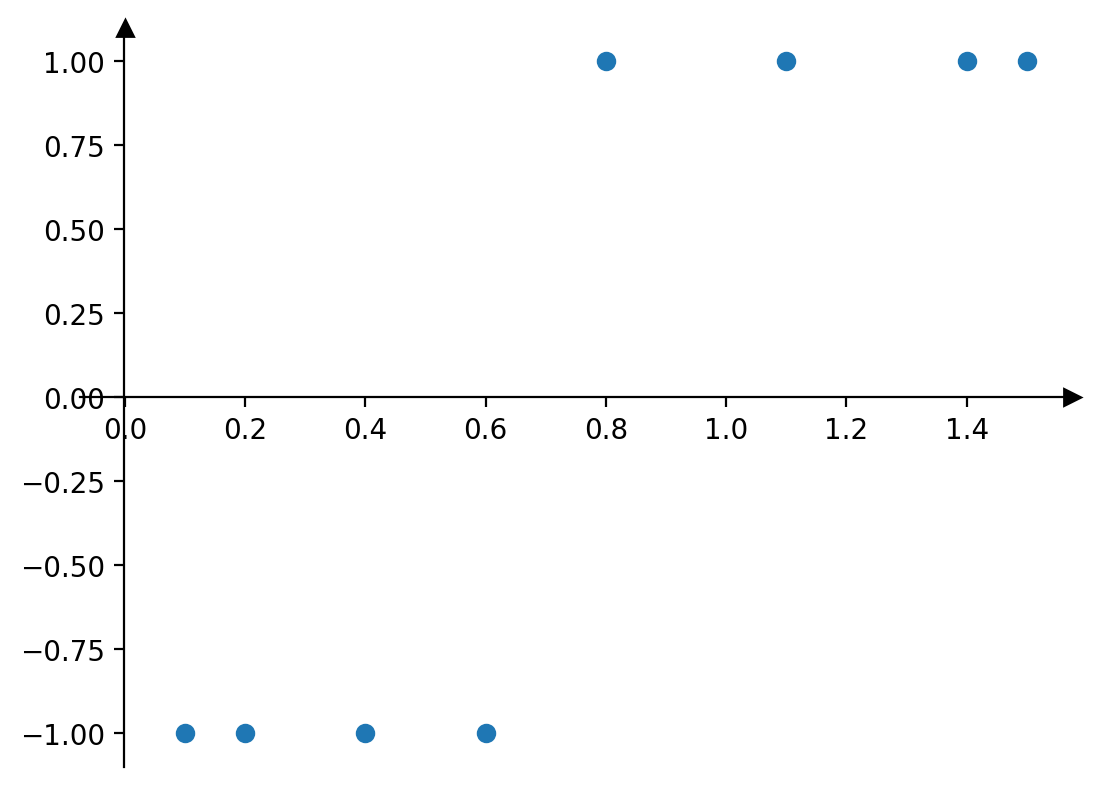

In [4]:
xx = np.array([0.1, 0.2, 0.4, 0.6,
               0.8, 1.1, 1.4, 1.5])
yy = np.array([-1, -1, -1, -1,
               1, 1, 1, 1])

if 1:
    
    fig = plt.figure(1)
    ax = fig.add_subplot(1, 1, 1)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position(('axes',0.045))
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
        
    ax.scatter(xx,yy)

Now let's fit a linear model to the training data:

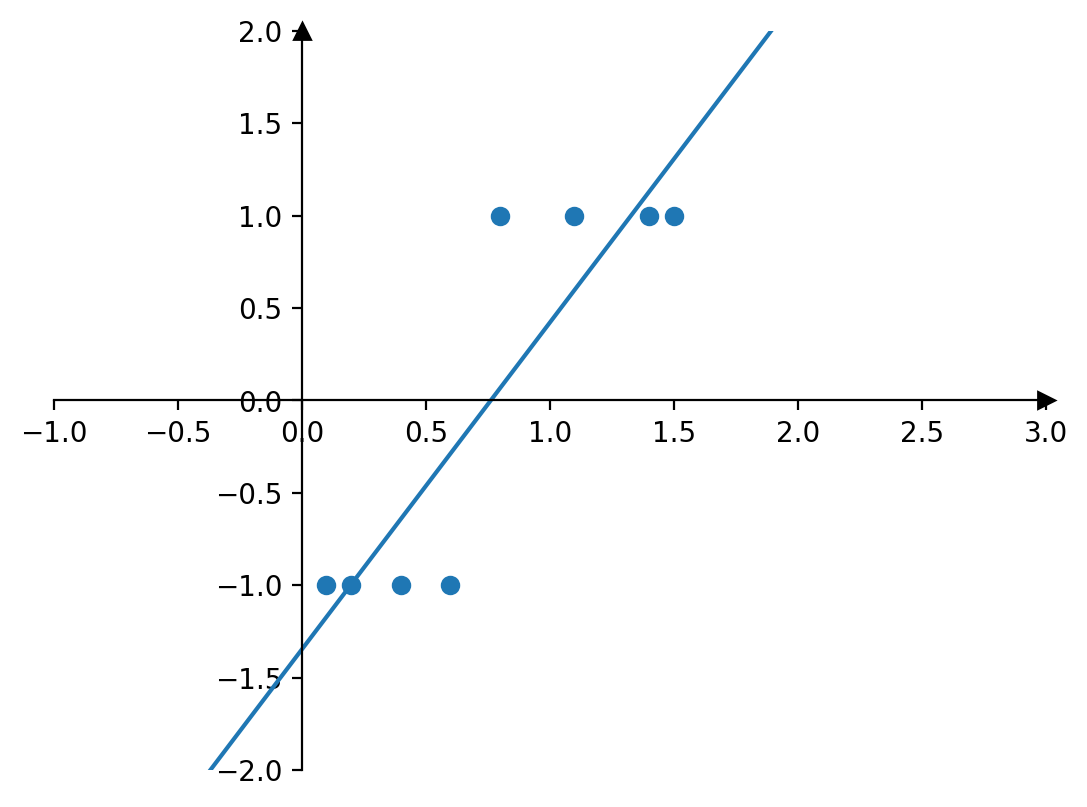

In [5]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(xx[:,None],yy)
ypred = linreg.predict(grid[:,None])

if 1:
    
    fig = plt.figure(1)
    ax = fig.add_subplot(1, 1, 1)

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position(('axes',0.25))
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
    
    ax.plot(grid,ypred)
    ax.set_xlim([-1,3])
    ax.set_ylim([-2,2])
        
    ax.scatter(xx,yy)

We see that for $x$ greater than about 1.3, $f(x)$ can indeed be larger than 1 and so can $y*f(x)$, which is indicating an increased certainty of the $+1$ class. 

OK, so now we can understand the plot, but we still need a loss function that makes sense for classification.

- The first we'll try is the so-called **["Zero-One Loss"](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.zero_one_loss.html)** shown in **black** below. It is 1 for $yf(x)<0$ and 0 for $yf(x)>0$; thus the name. You increment the loss function by 1 every time you make a wrong prediction. It is just a count of the total number of mistakes.

However, the Zero-One loss is hard to minimize, so instead we can try something that allows the loss to be continuous function in $y*f(x)$.  

- The **[Hinge Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html)**, which looks like
$${\rm max}(0,1-y*f(x)),$$
is plotted in **orange**. Here there is no contribution to the loss for values $\ge 1$, but there is a linearly increasing loss for smaller values. So, it penalizes both wrong predictions and also correct predictions that have low confidence.

- A **[Logistic Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss)** (also called the *log loss* and *cross entropy loss*) function has similar properties as shown in **blue**, but is smoother and has slightly less and less penalty for more and more confident $+1$ predictions.

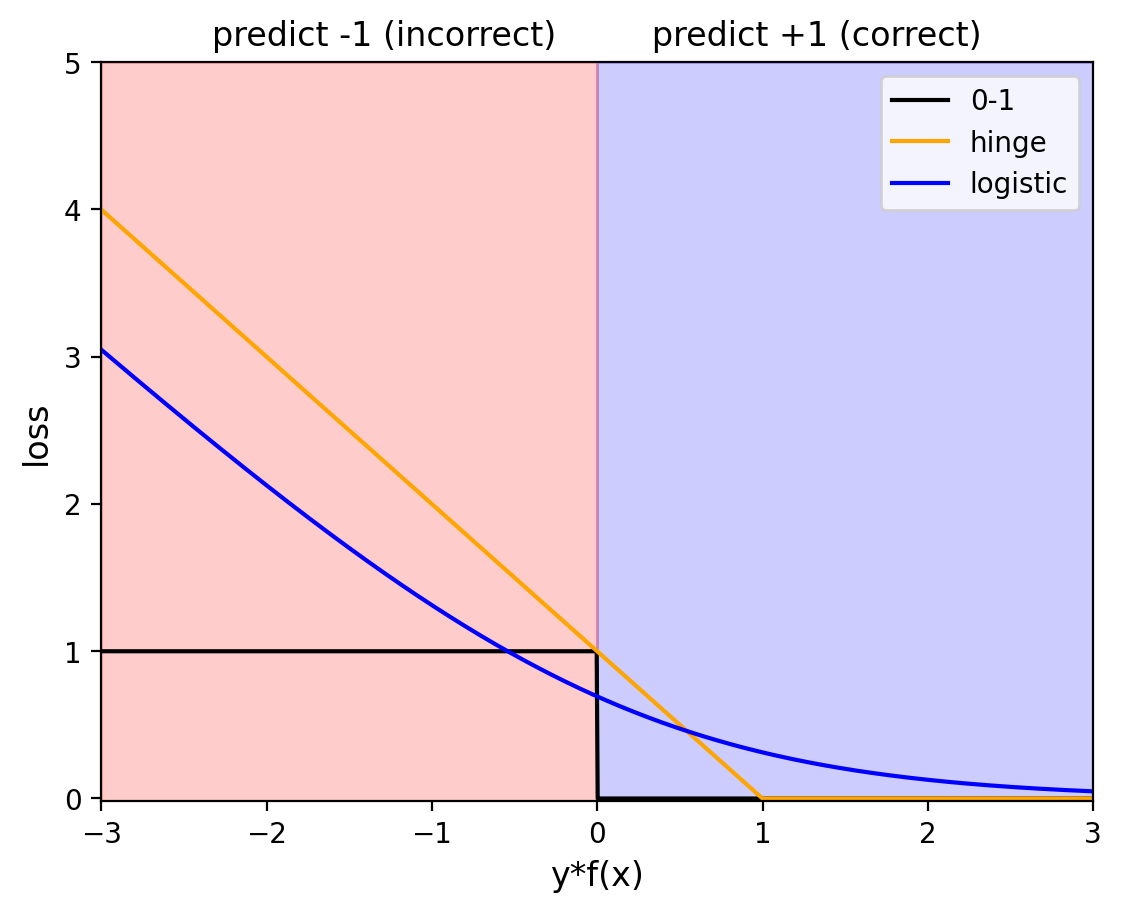

In [6]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)

plt.plot(grid, zero_one(grid), "k", label='0-1')
plt.plot(grid, hinge_loss(grid), "orange", label='hinge')
plt.plot(grid, log_loss(grid), "b", label='logistic')

plt.fill_between([0,3], y1=-0.02, y2=5,
                 color="b", alpha=0.2)
plt.fill_between([-3,0], y1=-0.02, y2=5,
                 color="r", alpha=0.2)
plt.xlim([-3,3])
plt.ylim([-0.02,5])
plt.xlabel("y*f(x)",fontsize=12)
plt.ylabel("loss",fontsize=12)
plt.title("predict -1 (incorrect)         predict +1 (correct)",fontsize=12)
plt.legend()

plt.show()

For more see
- [Linear Classsifiers in Python course](https://learn.datacamp.com/courses/linear-classifiers-in-python).
- https://datascience103579984.wordpress.com/2019/09/18/linear-classifiers-in-python-from-datacamp/
- https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23
- https://www.analyticsvidhya.com/blog/2019/08/detailed-guide-7-loss-functions-machine-learning-python-code
- http://www.datasciencecourse.org/notes/linear_classification/

## Gradient Descent <a class="anchor" id="two"></a>

That brings us to the topic of **[Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent)** for finding the optimal extremal position of a cost function.

Throughout this couse we have been trying to determine model parameters, $\theta$, that minimize either the regression error or the classification error when fitting our training data (and not overfitting!). 

- Sometimes we have been able to write an analytic solution for $\theta$.
- In MCMC we semi-randomly sampled the multi-dimensional $\theta$ space to find the best answer (and map the full parameter posterior distribution along the way). 
- But what happens if you are stuck on top of a freezing cold mountain and you have no map and can't magically jump from place to place? You start walking **down**. That's the basic idea of ***gradient descent***--take a look around you, figure out which way is sloping downward the most and go *that* way.

We are going to determine the local gradient of the loss function with respect to $\theta$ and go in the steepest direction, until the gradient is zero (and we have arrived at our destination).

Mathematically, for a simple linear model the MSE is defined as

$$ {\rm MSE}({\mathbf \theta}) = \frac{1}{N}(Y - X\theta)^T (Y - X\theta).$$

Therefore the partial derivative with respect to the vector of parameters $\theta$ is

$$\nabla_{\theta}{\rm MSE}({\mathbf \theta}) = \frac{2}{N}X^T(X\theta - Y).$$

That gives the uphill direction, but we want to move against the gradient, so we compute the next step as

$$\theta^{\rm next step} = \theta - \eta\nabla_{\theta}{\rm MSE}({\mathbf \theta}),$$

where $\eta$ is the **"learning rate"** and the rest are all matrices or vectors. 

- The initial values for $\theta$ are chosen randomly.
- The **[learning rate](https://en.wikipedia.org/wiki/Learning_rate)** controls how big your steps "down" are. 
- If your step size is too small, it will take too long to converge. 
- If it is too big, you might miss the bottom completely (and possibly end up diverging from the solution).  


![https://miro.medium.com/max/1400/0*GaO7X6j3coh3oNwf.png](https://miro.medium.com/max/1400/0*GaO7X6j3coh3oNwf.png)

We also have to be careful that we don't end up in a local minimum instead of the global minimum. One of the nice things about the $L2$ cost function is that it is guaranteed to have just a single global minimum. Gradient descent is also useful for regression where there are too many training points (or too many features) to fit into memory at a given time.

<font color='red'>Here's an example from Geron where we apply gradient descent to a simple linear regression problem.</font>

In [7]:
# Run the next 4 cells
# N points randomly drawn from a linear distribution
N = 100
X = 2 * np.random.rand(N, 1)
y = 4 + 3 * X + np.random.randn(N, 1)

# Turn X into a matrix
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each 

# Grid for plotting
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance

X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance

In [8]:
eta = 0.1  # learning rate
n_iterations = 100
theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/N * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [9]:
n_lines=10
color_idx = np.linspace(0, 1, n_lines)

# Helper function
theta_path_bgd = []
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            plt.plot(X_new, y_predict, color=plt.cm.cool(color_idx[iteration]))
            
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
            
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

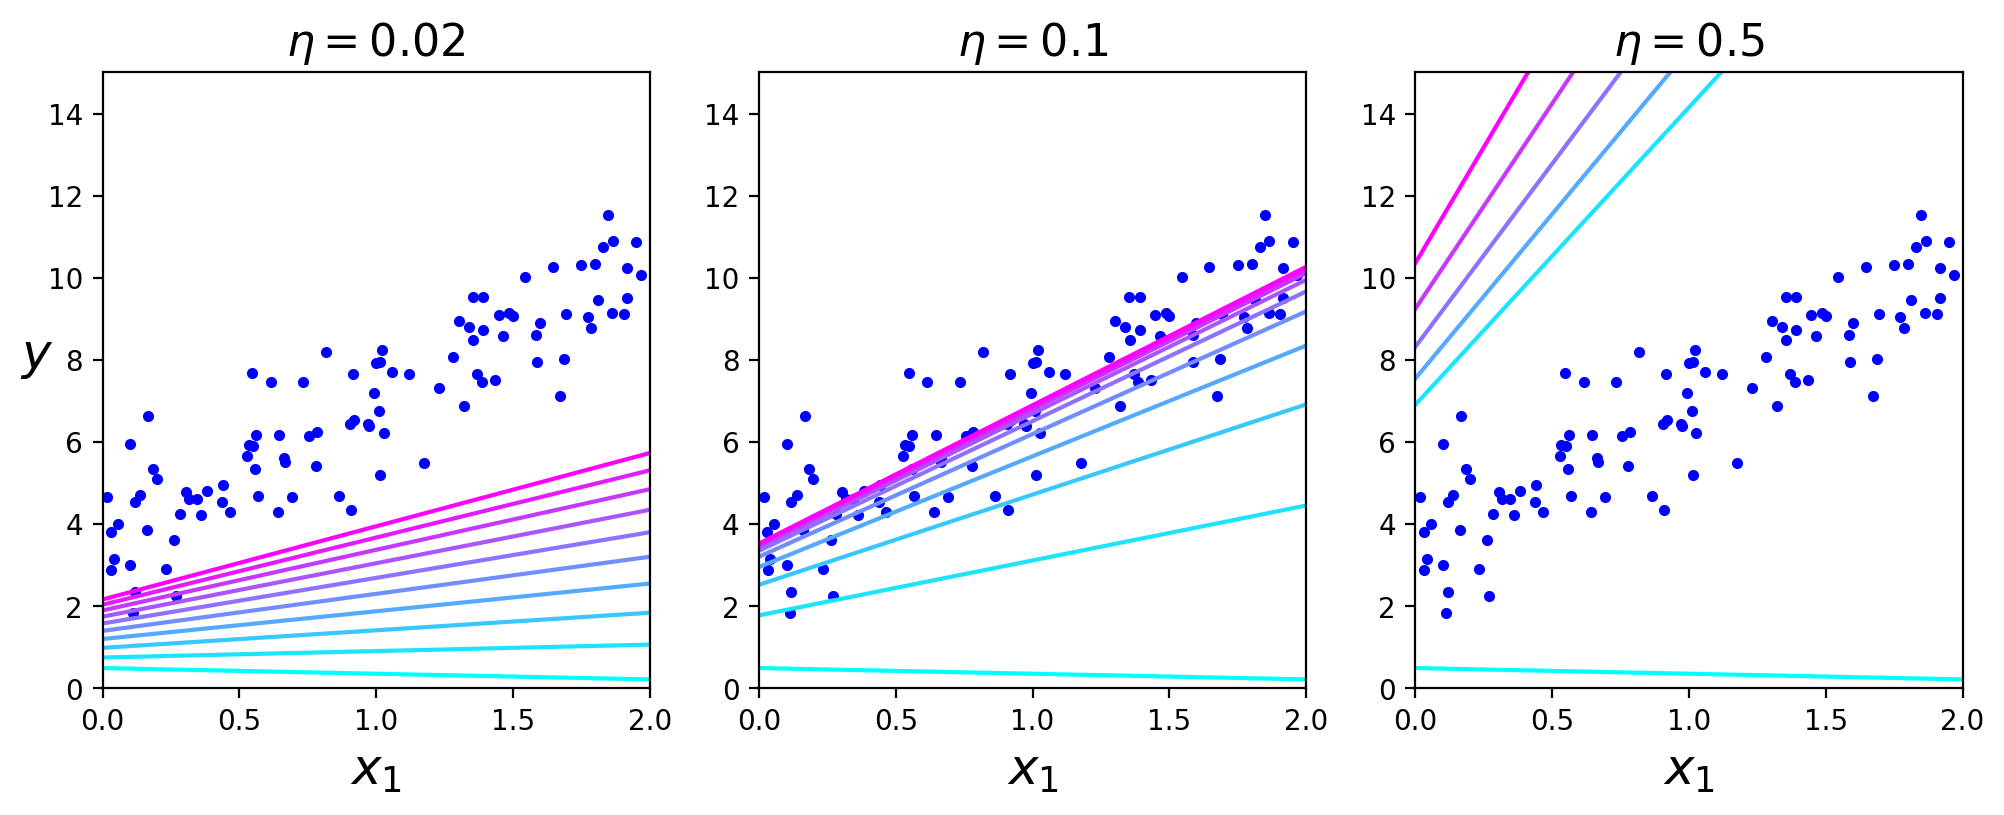

In [10]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization
plt.figure(figsize=(12,4))

plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)

plt.subplot(132); plot_gradient_descent(theta, eta=0.1, 
                                        theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.show()

We've got a "three bears" scenario.

- On the left our learning rate is too low. We'll eventually get to the solution, but it will take a long time.  
- On the right it is too high and we have completely missed the solution.  
- In the middle the learning rate is just right.

<font color='red'>Try $\eta = 0.3$ and $0.4$ to see if you can understand what is going on in the right panel.</font>

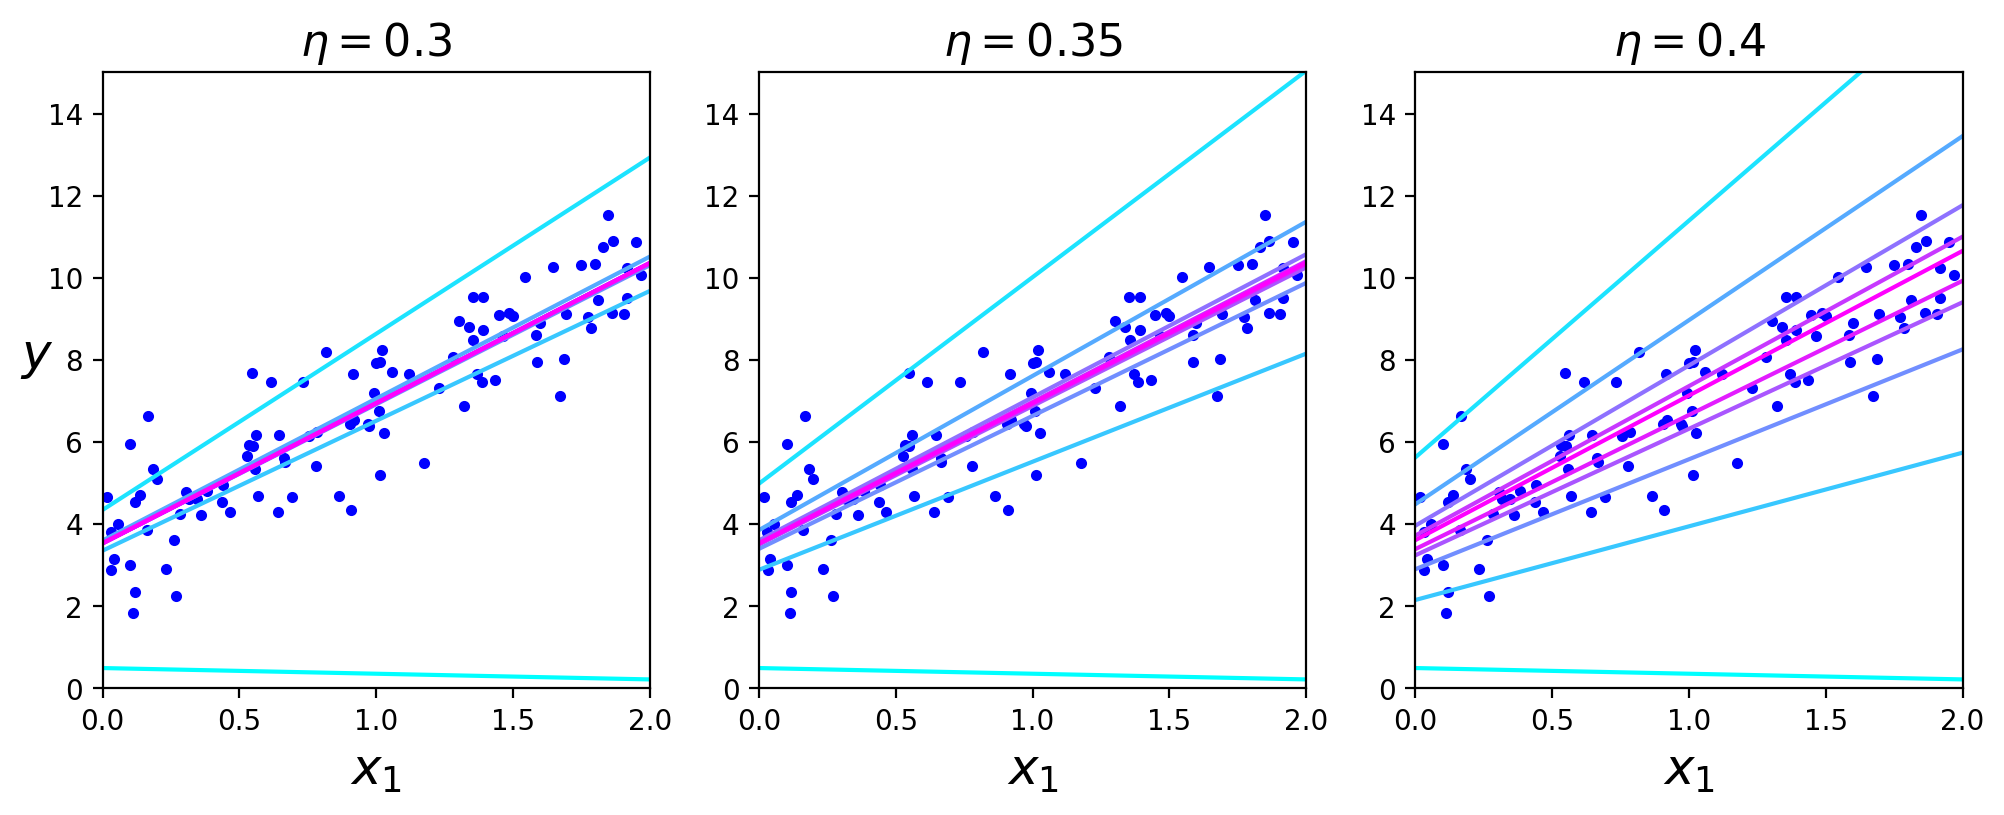

In [11]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization
plt.figure(figsize=(12,4))

plt.subplot(131); plot_gradient_descent(theta, eta=0.3)
plt.ylabel("$y$", rotation=0, fontsize=18)

plt.subplot(132); plot_gradient_descent(theta, eta=0.35, 
                                        theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.4)
plt.show()

## AdaBoost <a class="anchor" id="three"></a>

When I introduced Boosting in *Classification II*, I didn't mention **[AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)** or **[Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradient%20boosting#sklearn.ensemble.GradientBoostingClassifier)**, because it makes more sense to know about the other items above first. But ***AdaBoost = "Adaptive Boosting"***.

Below is an example of AdaBoost from Geron. <font color='red'>See what happens when you change the learning rate, where half the learning rate means that weights are boosted half as much for each iteration.</font>

In [12]:
# Run the next 3 cells
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
#Helper function for plotting
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, 
                           axes=[-1.5, 2.45, -1, 1.5], 
                           alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

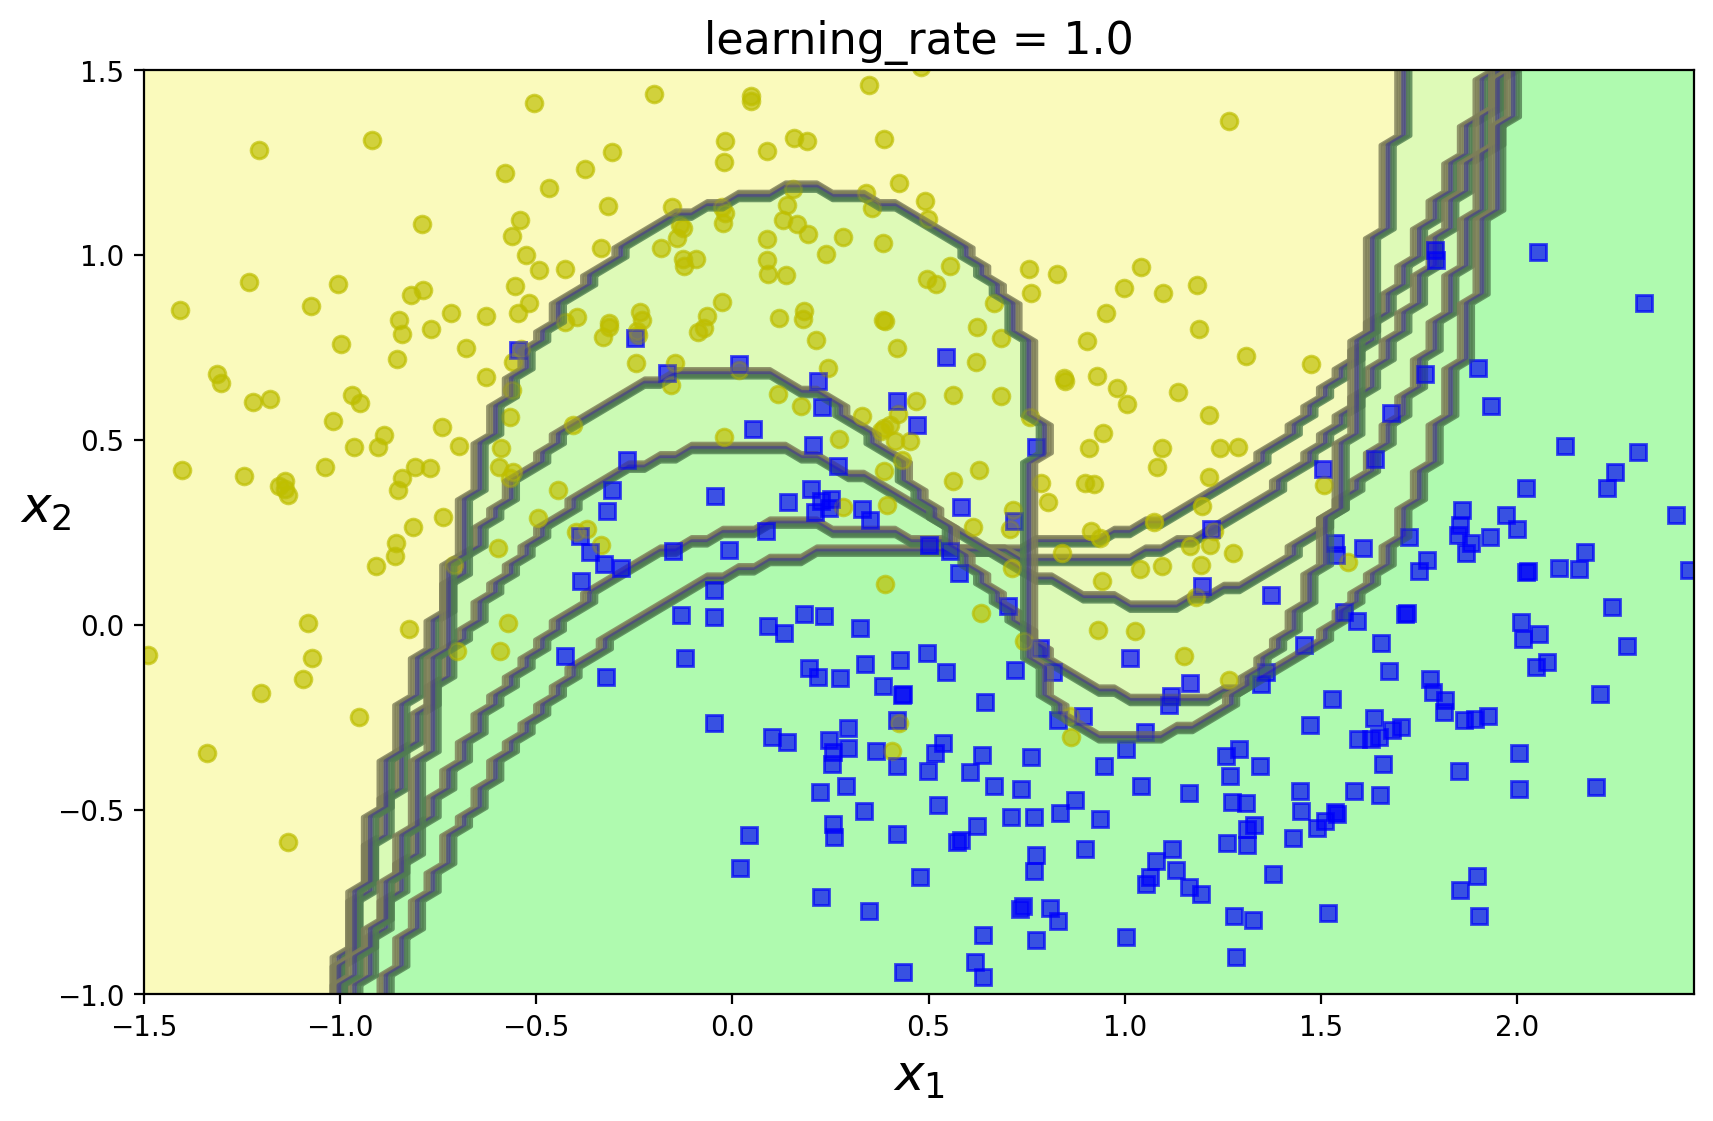

In [14]:
from sklearn.svm import SVC

learning_rate=1.0
m = len(X_train)

fix, axes = plt.subplots(ncols=1, figsize=(10,6))
sample_weights = np.ones(m)
for i in range(5):
    svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
    svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred = svm_clf.predict(X_train)
    sample_weights[y_pred != y_train] *= (1 + learning_rate)
    
    plot_decision_boundary(svm_clf, X, y, alpha=0.2)
    plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.show()

<font color='red'>Try some learning rates between $0.1$ and $1.0$.  It is important to note the order of these decision boundaries; that is, are they diverging?</font>

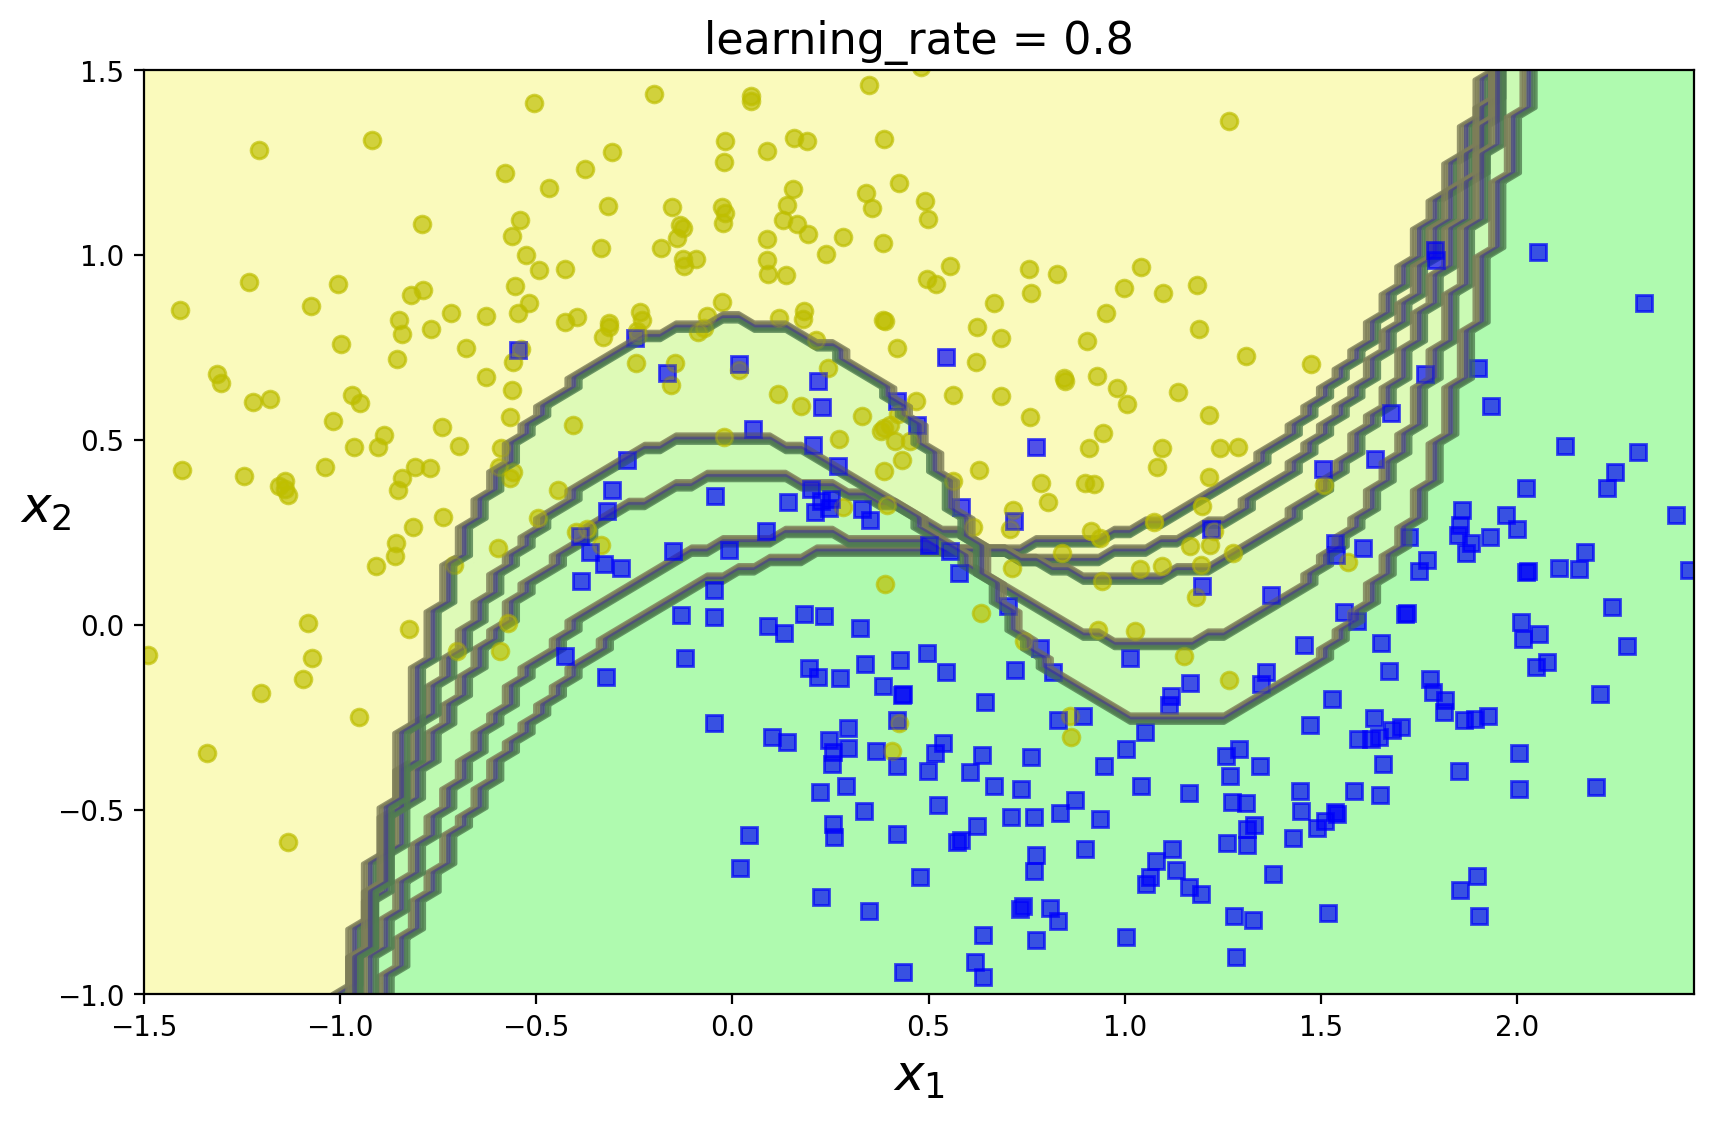

In [18]:
from sklearn.svm import SVC

learning_rate=0.8
m = len(X_train)

fix, axes = plt.subplots(ncols=1, figsize=(10,6))
sample_weights = np.ones(m)
for i in range(5):
    svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
    svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred = svm_clf.predict(X_train)
    sample_weights[y_pred != y_train] *= (1 + learning_rate)
    
    plot_decision_boundary(svm_clf, X, y, alpha=0.2)
    plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.show()

# Neural Networks <a class="anchor" id="four"></a>

**[Artificial Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_network)** are a simplified computational architecture based loosely on the real neural networks found in brains.

![Neuron example](https://4.bp.blogspot.com/-Z5LfY6yoIcE/U-OFKWHoAbI/AAAAAAAAAKo/ytH6BzDLeo4/s1600/Picture-533.png)

In reality, what we are going to explore is a **[multi-layer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)**.

In the image below, 
- the circles on the ***left*** represent the **features/attributes** of our input data, $X$, which here is 3 dimensional.  
- the circles in the ***middle*** represent the **neurons**. They take in the information from the input and, based on some criterion decide whether or not to "fire". These middle layers are called "**hidden layers**".
- the collective results of the neurons in the hidden layer produce the **output**, $y$, which is represented by the circles on the ***right***, which here is 2 dimensional result.  
- the lines connecting the circles represent the synapses.  

This is a simple example with just one layer of neurons; however, there can be many layers of neurons.

![Cartoon of Neural Network](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/500px-Artificial_neural_network.svg.png)

### In more detail

The job of a synapse is to take input values and multiply them by some **weight**, $w$, and add a **bias**, $b$, before passing them to the neuron (hidden layer):

$$z = \sum_i w x_i + b$$

The bias determines the input level at which the neuron "fires". It is always present, and unique to each neuron, but we'll set that to zero for the sake of simplicity here.

The neuron then sums up the inputs from all of the synapses connected to it and applies an "**activation function**", e.g., a **[sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function**.

$$a = \frac{1}{1+e^{-z}}.$$

![Sigmoid Function](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/500px-Logistic-curve.svg.png)

> ***The neural network learns the weights and biases of the synapses that are needed to produce an accurate model of $y_{\rm train}$.***

![Ivezic Figure 9.17](https://www.astroml.org/_images/fig_neural_network_1.png)

- Rather than think about the inputs individually, we can write this process in matrix form as
$$Z^{(2)} = X W^{(1)}$$


- If $D$ is the number of attributes and $H$ is the number of neurons in the hidden layer, then $X$ is an $N\times D$ matrix, while $W^{(1)}$ is a $D\times H$ matrix.  The result, $Z^{(2)}$, is then an $N\times H$ matrix.


- We then apply the activation function to each entry of $Z^{(2)}$ independently: 
$$A^{(2)} = f(Z^{(2)}),$$
where $A^{(2)}$ is the output of the neurons in the hidden layer and is also $N\times H$.


- These values are then the inputs for the next set of synapses, where we multiply the inputs by another set of weights, $W^{(2)}:$
$$Z^{(3)} = A^{(2)} W^{(2)},$$
where $W^{(2)}$ is an $H\times O$ matrix and $Z^{(3)}$ is an $N\times O$ matrix with $O$-dimensional output.


- Another (potentially different type of) activation function is then applied to $Z^{(3)}$ to give
$$\hat{y} = g(Z^{(3)}),$$
which is our estimator of $y$.

---

For example we might have $N=100$ people with known height and weight, for whom we have measured

1. shoe size
2. belt size
3. hat size 

We are going to use this to predict the height and weight for people where we only know shoe size, belt size, and hat size.

The neural network essentially boils down to determining the weights and biases of the synapses, which are usually initialized randomly. We do that by minimizing the cost function (which compares the true values of $y$ to our predicted values).  Typically an MSE cost:

$$ {\rm Cost} = J = \sum\frac{1}{2}(y - \hat{y})^2.$$

If we just had 1 weight and we wanted to check 1000 possible values, that wouldn't be so bad. ***But...*** if we have 20 weights, that means checking $20^{1000}$ possible combinations. Remember the curse of dimensionality?  That might take a while. Indeed, far, far longer than the age of the Universe.

### Backpropagation

However some clever techniques have evolved out of realizing that we can write an **analytic formula for the *gradient* going backwards through the network, and use that to update our weights (and biases, of course)**.

For example, how about just checking 3 points for each weight and see if we can at least figure out which way is "down hill"? That's a start. We can rewrite $J$ as

$$ J = \sum\frac{1}{2}\left[y - g\left( f(X W^{(1)}) W^{(2)} \right) \right]^2$$

and then compute

$$\frac{\partial J}{\partial W}$$

in order to determine the slope of the cost function for each weight.  This is the **gradient descent** method, which we encountered before.  Your choice of cost function is important here; specifically you want it to be differentiable.

We'll want $\partial J/\partial W^{(1)}$ and $\partial J/\partial W^{(2)}$ separately. This allows us to ***[backpropagate](https://en.wikipedia.org/wiki/Backpropagation)*** the error contributions along each neuron and to change the weights where they most need to be changed.  It is like each observation gets a vote on which way is "down hill".  We compute the vector sum to decide the ultimate down hill direction.

Once we know the down hill direction from the derivative, we update the weights by subtracting a scalar (the *learning rate*) times that derivative from the original weights-- this is just gradient descent! This is obviously much faster than randomly sampling all the possible combinations of weights.  

<font color='red'>Watch the following short video to understand more of the mathematics of **backpropagation (= "backward propagation of errors")**.</font>

In [19]:
from IPython.display import YouTubeVideo
YouTubeVideo('https://www.youtube.com/watch?v=GlcnxUlrtek&list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU&index=4&ab_channel=WelchLabs', width=1000, height=500)

***Once the weights and biases are set through training, you've got your Neural Network classifier/regressor.***

![Ivezic Figure 9.17](https://www.astroml.org/_images/fig_neural_network_1.png)

Scikit-Learn has both **[unsupervised Neural Network](http://scikit-learn.org/stable/modules/neural_networks_unsupervised.html#neural-networks-unsupervised)** and **[supervised Neural Network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised)** examples. 

<font color='red'>Let's try to use the **multi-layer perceptron classifier** on the Iris dataset (using 75% of the data for training and 25% for testing).</font>

In [38]:
from sklearn.datasets import  load_iris
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

iris = load_iris()

X = iris.data
y = iris.target

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Xtrain_scaled = preprocessing.scale(Xtrain)
Xtest_scaled = preprocessing.scale(Xtest)
Xscaled = preprocessing.scale(X)
print(len(Xscaled),len(y))

150 150


[(4, 5), (5, 2), (2, 1)]


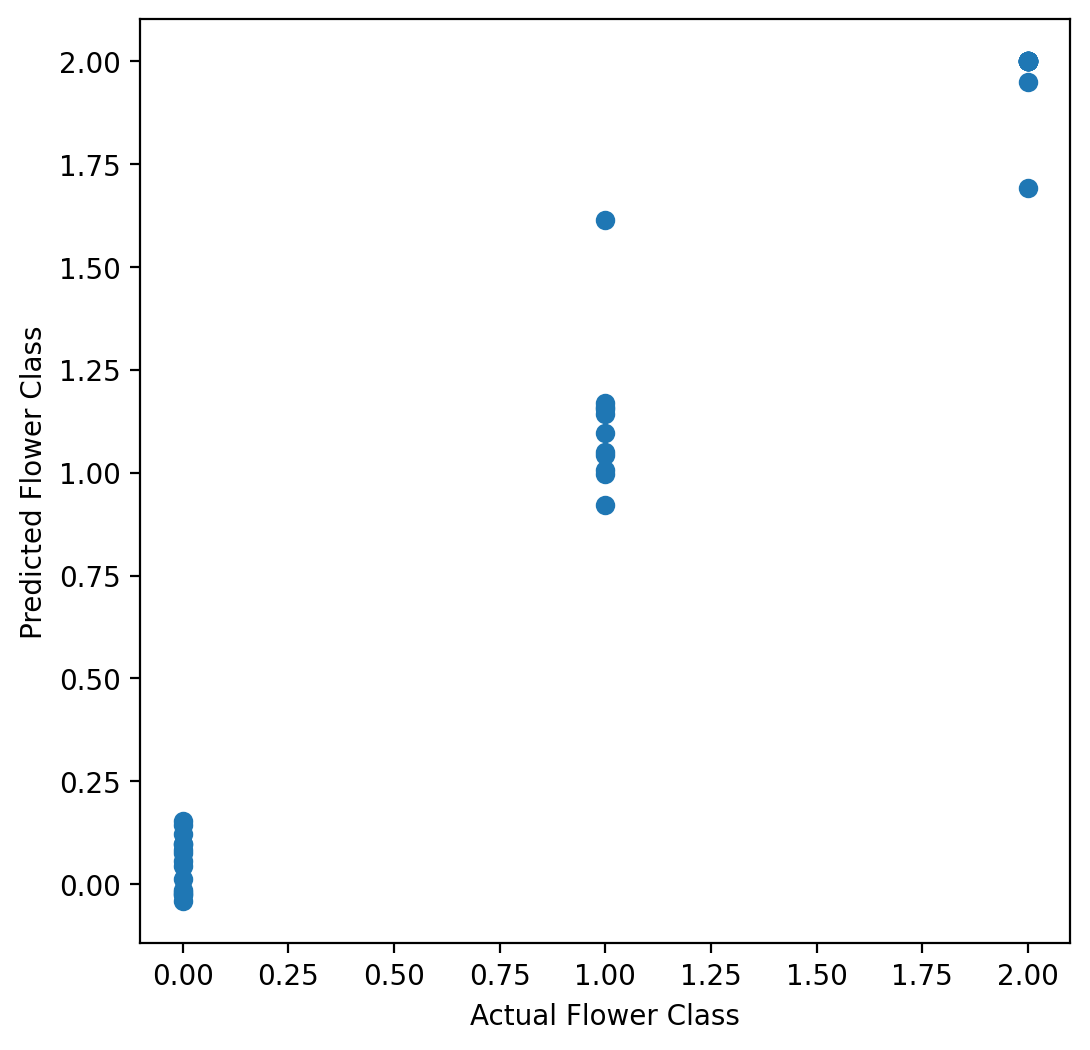

In [21]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(solver='lbfgs', alpha=1e-5, 
                   hidden_layer_sizes=(5,2), 
                   random_state=1, max_iter=5000)
clf.fit(Xtrain_scaled, ytrain)

# Look at the weights
print([coef.shape for coef in clf.coefs_])

ypred = clf.predict(Xtest_scaled)

fig = plt.figure(figsize=(6, 6))
plt.scatter(ytest,ypred)
plt.xlabel("Actual Flower Class")
plt.ylabel("Predicted Flower Class")
plt.show()

Of course, that only predicts the value for a fraction of the data set. <font color='red'>Again, we can use Scikit-Learn's [cross_val_predict](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) to make predictions for the full data set.</font>

150 150


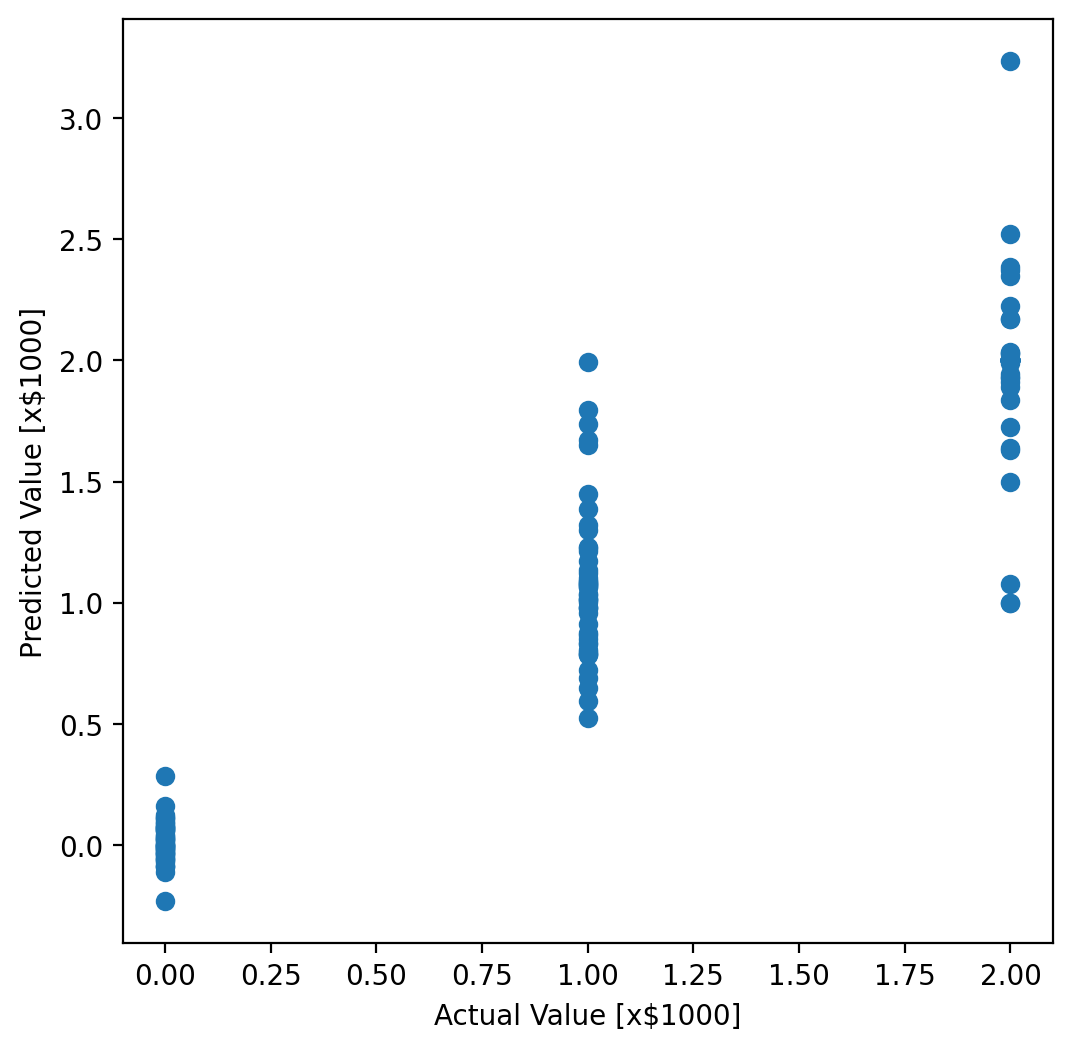

In [39]:
from sklearn.model_selection import cross_val_predict

yCVpred = cross_val_predict(clf, Xscaled, y, cv=5) # Complete
print(len(y) , len(yCVpred))
fig = plt.figure(figsize=(6, 6))
plt.scatter(y,yCVpred)

plt.xlabel("Actual Value [x$1000]")
plt.ylabel("Predicted Value [x$1000]")
plt.show()

Just as with other model hyperparameters, we can use cross-validation to determine the optimal number of layers, neurons per layer, etc. But for now, let's talk about some guidelines.

### Number of Layers

*Ivezic*: 

> "*For data that can be represented by a linear model, no layers are required (McCullagh & Nelder 1989).  A single layer network can approximate any continuous function.  Two layers can represent arbitrary decision boundaries for smooth functions (Lippmann 1987).  More layers can represent non-continuous or complex structure within the data.*"  

Think about why no layers are needed for linear regression.  We just connect our input to the output where the synapses are the weights (slopes) and the output neurons add the constant (intecept).

So you might start with a single layer, then add more layers and use cross-validation to determine when you are overfitting.

Say you had to draw a whole forest, but you couldn't cut and paste anything.  That would be very tedious.  But if you could draw just one leaf and copy that to make a small branch, then scale up a small branch to a big branch and copy that, then attach the branches to a tree trunk and then make copies of the full tree, you wouldn't have to draw all that much. **Each of the layers in a neural network handles more and more detailed aspects of the problem.**  

For image recognition, you might need dozens of layers, but also a huge training set to populate those layers.

### Number of Neurons

The number of neurons in each layer is also a free parameter. 

- ***Typically choose somewhere between twice the number of input nodes and a number between the number of input and output nodes.***


- If there are lots hidden layers (where "lots" is not clearly defined) then we call that a **deep neural network or [deep learning](https://en.wikipedia.org/wiki/Deep_learning)**. 


- Sometimes the number of neurons in each layer goes down.  But it can also be useful to have the same number in each layer so that there is only one hyperparameter (the number of neurons) and not one per layer.


- In practice a reasonable approach is to simply **specify many more layers and neurons than you need and perform regularization**. This can be as simple as just stopping the training when the cross-validation error reaches a minimum, which appropriately (for once) is called **[early stopping](https://en.wikipedia.org/wiki/Early_stopping)**. Basically, you put your `fit` method into a loop and instantiate with `max_iter=1` and `warm_start=True`.


While the number of neurons in the hidden layers are free parameters the number of input and output nodes are constrained by the data and the desired output.  For example, the MNIST digits data requires 784 input neurons (one for each pixel in the 28x28 images) and 10 output neurons (one for each class [digit]).  

### Activation Functions

The **[Activation function](https://en.wikipedia.org/wiki/Activation_function)** controls how much "signal" it takes for a neuron to "fire".  The more signal, the more likely the neuron will fire. See https://mlfromscratch.com/activation-functions-explained/#/

The cells below show different activation functions, using the same visualization as we used for loss functions.

In [40]:
# Mathematical formulas for activation functions
  
def binary(raw_model_output):
    return np.where(raw_model_output < 0, 
                    0, 
                    1)  

def sigmoid(raw_model_output):
    return 1.0 / (1 + np.exp(-raw_model_output))

def ReLU(raw_model_output):
    return np.where(raw_model_output < 0, 
                    0, 
                    raw_model_output)

def LReLU(raw_model_output):
    alpha=0.1
    return np.where(raw_model_output < 0, 
                    alpha*raw_model_output, 
                    raw_model_output)

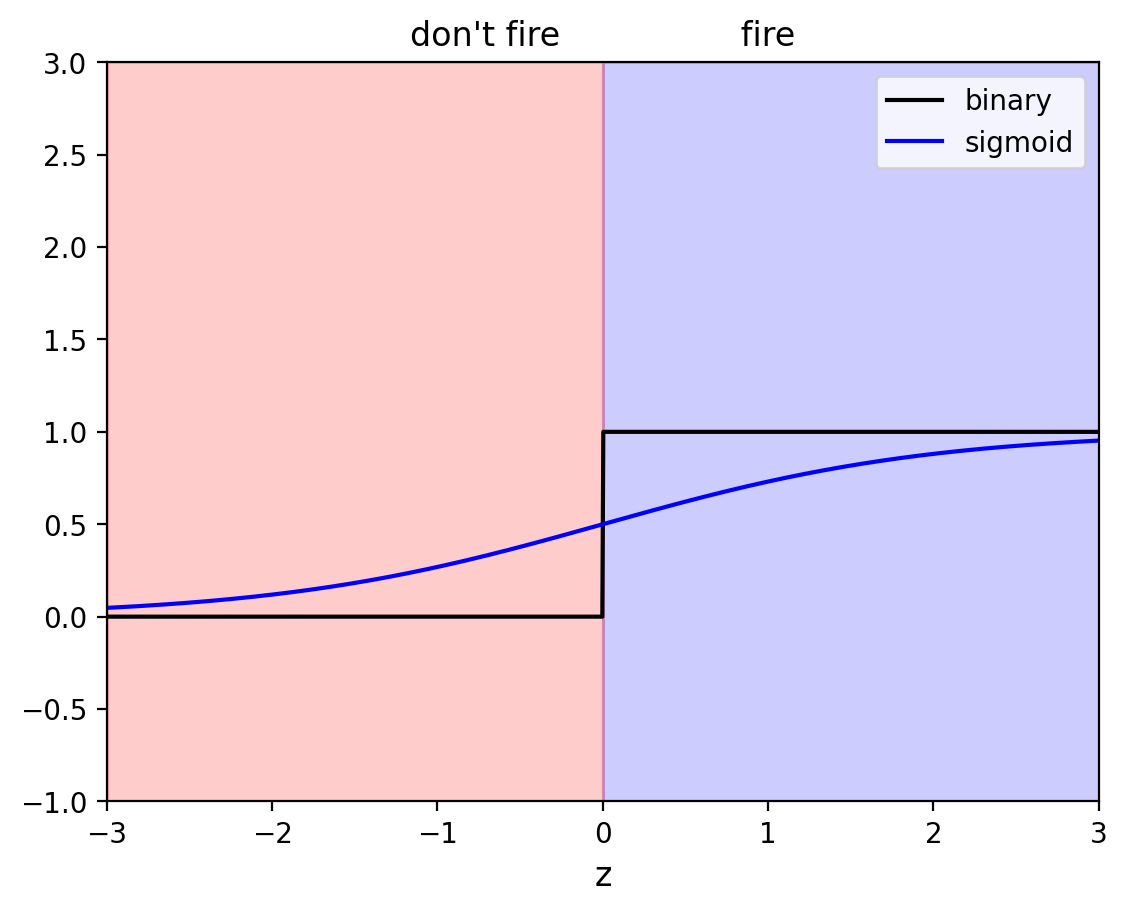

In [41]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
#plt.plot(grid, log_loss(grid), label='logistic')
plt.plot(grid, binary(grid), "k", label='binary')
plt.plot(grid, sigmoid(grid), "b", label='sigmoid')
#plt.plot(grid, ReLU(grid), label='ReLU')
#plt.plot(grid, LReLU(grid), label='LReLU')
#plt.plot(grid, l2(grid), label='L2')
#plt.plot(grid, l1(grid), label='L1')

plt.fill_between([0,3], y1=-1, y2=3, 
                 color="b", alpha=0.2)
plt.fill_between([-3,0], y1=-1, y2=3, 
                 color="r", alpha=0.2)
plt.xlim([-3,3])
plt.ylim([-1,3])
plt.xlabel("z",fontsize=12)
plt.title("don't fire                 fire",fontsize=12)
plt.legend()

plt.show()

"*On vs. Off*" activation actually isn't quite true or what we want. The way your eyes work is that you need 1-10 photons to trigger a rod, but several rods must be triggered to send a signal to the brain. The sigmoid activation function captures the probabilistic nature of neuron firing. More importantly it is differentiable, so can be used for backpropagation.

Another important aspect of non-linear activation functions is that they are what allow neural networks to solve non-linear problems.  If we used a strictly linear activation function, then we could only solve linear problems.  That is, you could fit a straight line, but not an exponential.


#### Vanishing and Exploding Gradients

However, neural network research suffered significant limitations and problems at the hands of the [vanishing and exploding gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem.  We won't go into detail there except to say that ***around 2010 there were suggestions for different activation functions that were published.***  

- For example, the **[Rectified Linear Unit (ReLU) activation function](https://www.wikiwand.com/en/Rectifier_(neural_networks))** is another commonly used activation function as it solves the vanishing gradient problem (since the gradient is only 0 or 1).
$${\rm ReLU}(z) = max(0,z)$$


- It isn't ideal both because the derivative is 0 for $z<0$ and it can end up producing dead nodes. However, it is fast and the resulting sparsity can be good (sort of like regularization).


- A number of papers since 2015 describe various improvements, including the **Leaky ReLU**, the **exponential linear unit (ELU)**, and **scaled exponential linear unit (SELU)**.


Note that the activation functions can be different in different layers.  For example, for regression, one typically doesn't use any activation function in the output layer as including one would restrict the range of possible outputs.

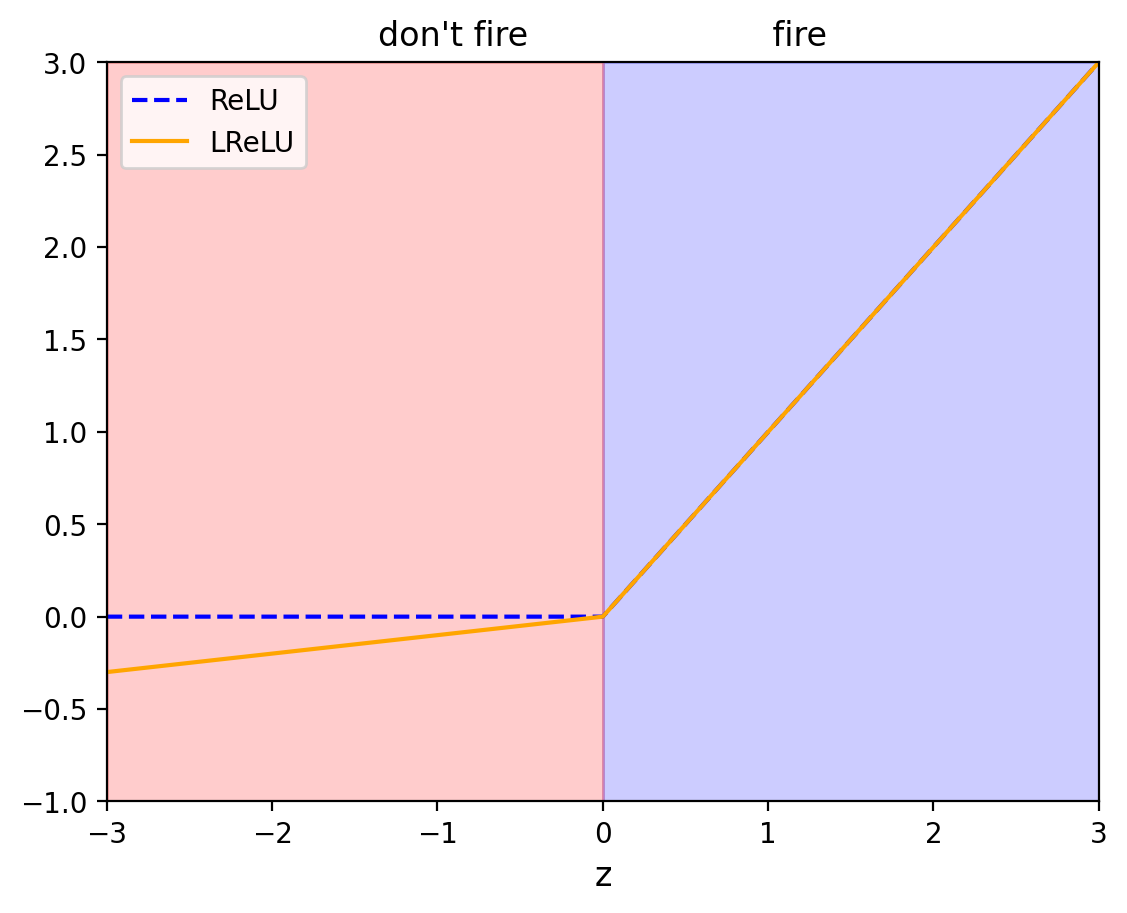

In [42]:
# Create a grid of values and plot
grid = np.linspace(-3,3,1000)
#plt.plot(grid, log_loss(grid), label='logistic')
#plt.plot(grid, binary(grid), "k", label='binary')
#plt.plot(grid, sigmoid(grid), "b", label='sigmoid')
plt.plot(grid, ReLU(grid), "b--", label='ReLU')
plt.plot(grid, LReLU(grid), "orange", label='LReLU')
#plt.plot(grid, l2(grid), label='L2')
#plt.plot(grid, l1(grid), label='L1')

plt.fill_between([0,3], y1=-1, y2=3, 
                 color="b", alpha=0.2)
plt.fill_between([-3,0], y1=-1, y2=3, 
                 color="r", alpha=0.2)
plt.xlim([-3,3])
plt.ylim([-1,3])
plt.xlabel("z",fontsize=12)
plt.title("don't fire                       fire",fontsize=12)
plt.legend()

plt.show()

Some general guidance on activation functions:
    
* **Use sigmoid for output of binary classification (with binary cross entropy loss)**


* **Use ReLU for layers other than output (at least to start with because it is faster)**


* **Use softmax for output with more than 2 classes (with categorical cross entropy loss)**

### Regularization

Just as we can use regularization for standard regression and classification tasks, so too can we with neural networks.  

Not only can we apply the usual $L1$ (LASSO) or $L2$ (Ridge) regularization techniques, we can also use **dropout** which, as the name indicates, causes some neurons to be temporarily "dropped out" during training (usually by setting some probability for that to happen, typically 10-50%). After training, all of the neurons are used.

*Geron* explains this in terms of a company needing to try to figure out how to adapt to a crucial employee being out sick for a period of time.  In the end, it can make the company stronger as more people (neurons) are able to handle certain parts of the process.


### Batch normalization

Just as it is often necessary to normalize or standardize our features, sometimes it is helpful to do the same to the output of the hidden layers.  This is called **[batch normalization](https://en.wikipedia.org/wiki/Batch_normalization)** and is done before passing the data to the activation function.  It make the process more stable and can also make it faster.  We'll do an example next time. 


### Faster Optimizers

We aren't going to talk about optimizers, but it might be useful for you to have some options to feed into a search for the best parameter using cross validation.  For example **`['mse', 'adam', 'sgd', 'adagrad']`**.